In [ ]:
import kagglehub
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img # Added import for load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 # For preprocessing
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.io import imread
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split # <--- Make sure this line is present
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.utils import to_categorical # For one-hot encoding if needed
# --- Your Kagglehub Data Download (as above) ---
# Download latest version
folder_path = kagglehub.dataset_download("janithukwattage/stress-faces-dataset")

print("Path to dataset files:", folder_path)
folder_path=folder_path+"/facesData/"
picture_size = 48
#folder_path = 'C:/Users/asus/OneDrive/Desktop/projectfinal2025/facedata/facesdata/'

Path to dataset files: /kaggle/input/stress-faces-dataset


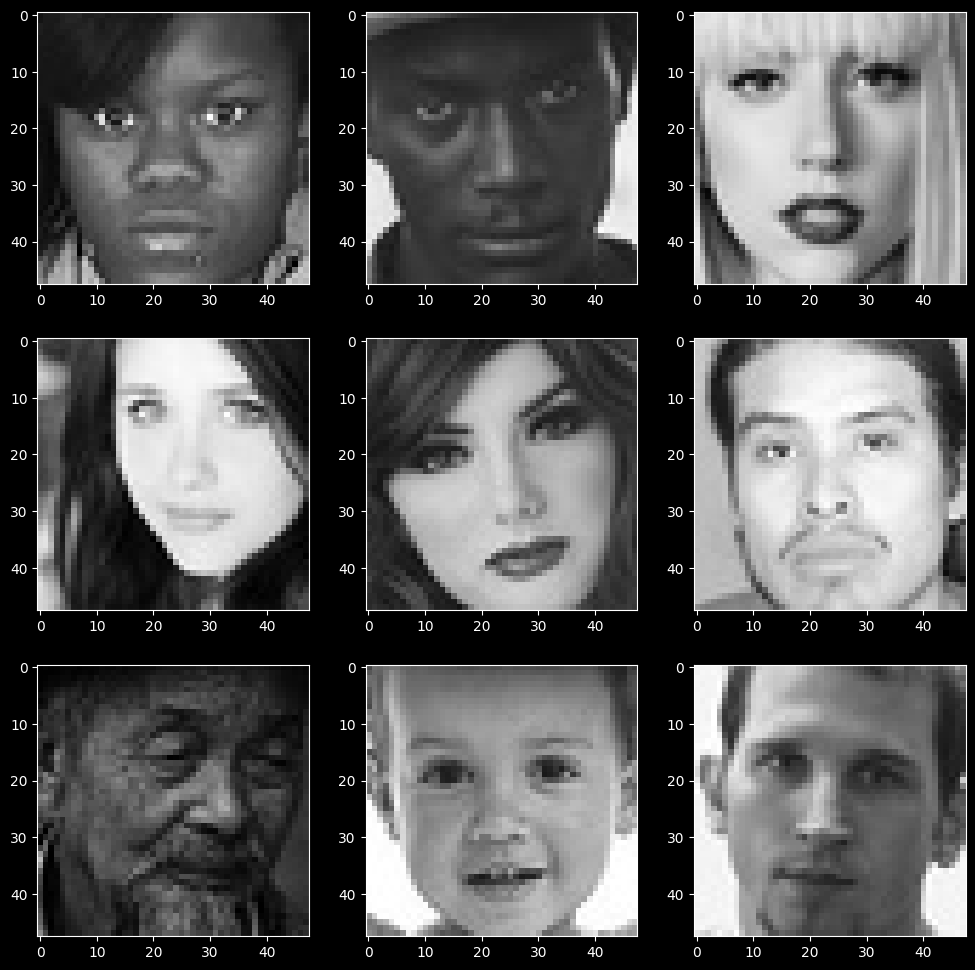

In [ ]:

expression = 'nostress'
plt.style.use('dark_background')
plt.figure(figsize=(12,12))
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"test/"+expression+"/"+ os.listdir(folder_path+"test/"+expression)[i],target_size=(picture_size,picture_size))
    plt.imshow(img)
plt.show()

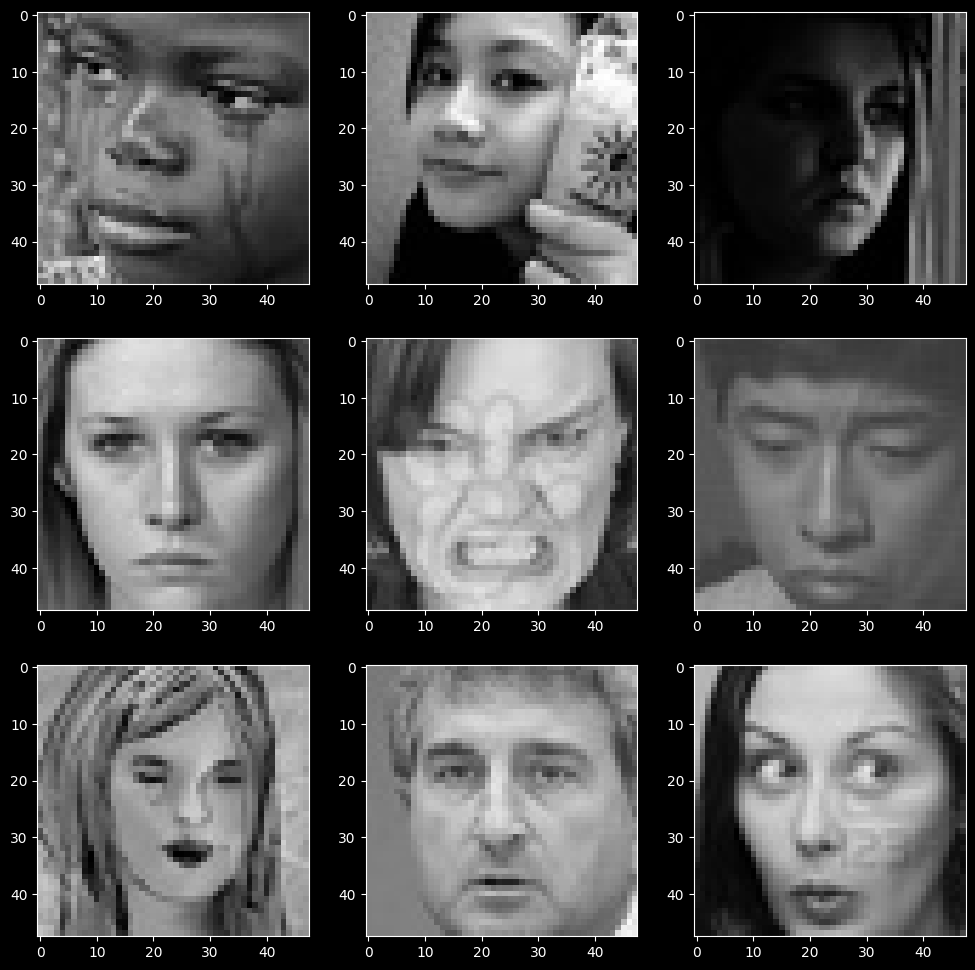

In [ ]:
expression = 'stress'
plt.style.use('dark_background')
plt.figure(figsize=(12,12))
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"test/"+expression+"/"+ os.listdir(folder_path+"test/"+expression)[i],target_size=(picture_size,picture_size))
    plt.imshow(img)
plt.show()

In [ ]:
folder_path = kagglehub.dataset_download("janithukwattage/stress-faces-dataset")
base_data_path = os.path.join(folder_path, "facesData")
picture_size = 48
def preprocess_face_image(image_path, target_size=(48, 48), augment=True): # Example size, adjust as per your model's input
    try:
        # Load as grayscale if your model expects single channel (e.g., for stress detection from facial expressions)
        # If your images are RGB, remove 'as_gray=True' and adjust 'your_channels' in model
        img = imread(image_path, as_gray=True)
        img = resize(img, target_size, anti_aliasing=True) # Resize to target size

        # Convert to 8-bit for OpenCV functions if needed, then normalize to [0,1]
        img_8bit = (img * 255).astype(np.uint8)

        # Apply histogram normalization to enhance contrast
        img_processed = cv2.equalizeHist(img_8bit) # Using equalizeHist for grayscale
        img_processed = img_processed.astype(np.float32) / 255.0 # Normalize back to [0,1]

        # Apply Gaussian Blur (can help reduce noise, consider if beneficial for stress features)
        img_processed = cv2.GaussianBlur(img_processed, (3, 3), 0) # Small kernel for blur

        if augment:
            if random.random() > 0.5: # Random rotation
                img_processed = rotate(img_processed, random.uniform(-10, 10), mode='edge')
            if random.random() > 0.5: # Random horizontal flip
                img_processed = np.fliplr(img_processed)
            if random.random() > 0.5: # Random translation
                transform = AffineTransform(translation=(random.uniform(-0.1 * target_size[0], 0.1 * target_size[0]),
                                                        random.uniform(-0.1 * target_size[1], 0.1 * target_size[1])))
                img_processed = warp(img_processed, transform, mode='edge')

        return img_processed
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
train_image_paths = []
train_labels = []
test_image_paths = []
test_labels = []

label_map = {'nostress': 0, 'stress': 1}
num_classes = len(label_map)

train_data_dir = os.path.join(base_data_path, 'train')
for category_name, label_id in label_map.items():
    category_path = os.path.join(train_data_dir, category_name)
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                train_image_paths.append(img_path)
                train_labels.append(label_id)

test_data_dir = os.path.join(base_data_path, 'test')
for category_name, label_id in label_map.items():
    category_path = os.path.join(test_data_dir, category_name)
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                test_image_paths.append(img_path)
                test_labels.append(label_id)
X_train_paths, X_val_paths, y_train_labels_split, y_val_labels_split = train_test_split(
    train_image_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

print("Preprocessing training images...")
X_train = np.array([preprocess_face_image(path, target_size=(picture_size, picture_size), augment=True) for path in X_train_paths])
y_train = np.array(y_train_labels_split)

print("Preprocessing validation images...")
X_val = np.array([preprocess_face_image(path, target_size=(picture_size, picture_size), augment=False) for path in X_val_paths])
y_val = np.array(y_val_labels_split)

print("Preprocessing test images...")
X_test = np.array([preprocess_face_image(path, target_size=(picture_size, picture_size), augment=False) for path in test_image_paths])
y_test = np.array(test_labels)

X_train = X_train.reshape(X_train.shape[0], picture_size, picture_size, 1)
X_val = X_val.reshape(X_val.shape[0], picture_size, picture_size, 1)
X_test = X_test.reshape(X_test.shape[0], picture_size, picture_size, 1)

print("Image preprocessing complete. Data shapes:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Preprocessing training images...
Preprocessing validation images...
Preprocessing test images...
Image preprocessing complete. Data shapes:
X_train shape: (7836, 48, 48, 1), y_train shape: (7836,)
X_val shape: (1959, 48, 48, 1), y_val shape: (1959,)
X_test shape: (2480, 48, 48, 1), y_test shape: (2480,)


In [ ]:
 # (Keep this function as defined in previous responses)
def create_face_stress_model(input_shape=(48, 48, 1), num_classes=2): # Adjusted default input_shape for clarity
    inputs = keras.Input(shape=input_shape, name="face_input")

    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer: Ensure this matches your class_mode='categorical'
    # If num_classes is 2, and class_mode='categorical', labels are [1,0], [0,1].
    # So activation should be 'softmax' and loss 'categorical_crossentropy'.
    outputs = layers.Dense(num_classes, activation="softmax", name="stress_output")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="face_stress_model")
    return model



In [ ]:

# --- 3. Training and Evaluation Functions ---
# (Keep these functions as defined in previous responses, with minor loss adjustment)
def train_model(model, train_generator, val_generator, epochs=50):
    # Compile the model for categorical classification
    model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"]) # <--- Changed loss

    # EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

    print("Starting model training...")
    history = model.fit(
        train_generator, # Use train_generator directly
        epochs=epochs,
        validation_data=val_generator, # Use val_generator directly
        callbacks=[early_stopping],
        verbose=1
    )
    print("Model training finished.")
    return model, history

def evaluate_model(model, test_generator):
    print("Starting model evaluation...")
    # Evaluate with the test_generator
    evaluation_results = model.evaluate(test_generator, verbose=1)
    print("\n--- Evaluation Results ---")
    print(f"Test Loss: {evaluation_results[0]:.4f}")
    print(f"Test Accuracy: {evaluation_results[1]:.4f}")

    # For detailed metrics like Precision, Recall, F1, ROC AUC, you need to predict all at once
    # and then calculate metrics. This can be memory intensive for large test sets.
    # If test_generator provides one-hot encoded labels, y_true will be one-hot.
    y_pred_probs = model.predict(test_generator)
    y_true_labels = test_generator.classes # Get true labels as integers
    # Get predicted labels as integers
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    # Decode labels back if you need original category names for confusion matrix
    # If you used LabelEncoder previously, you can use label_encoder.inverse_transform()

    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average='macro') # Use 'macro' for multi-class
    recall = recall_score(y_true_labels, y_pred_labels, average='macro')
    f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

    # ROC AUC for multi-class requires probabilities for each class
    # If your output is one-hot (categorical), you'd need the raw probabilities (y_pred_probs)
    # roc_auc = roc_auc_score(y_true_labels, y_pred_probs, multi_class='ovr') # 'ovr' (One-vs-Rest) or 'ovo' (One-vs-One)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    # print(f"ROC AUC (OVR): {roc_auc:.4f}") # Uncomment if needed and ensure y_true_labels is one-hot or handled correctly

    # Confusion Matrix Plot
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    # Get class names from the generator
    class_names = list(test_generator.class_indices.keys())
    plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("Evaluation finished.")

In [ ]:

# --- Updated Data Loading using ImageDataGenerator ---
print("Setting up ImageDataGenerators...")

# Data augmentation for training set
datagen_train = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0,1]
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.2 # 20% of training data for validation
)

# No augmentation for test set, only rescaling
datagen_test = ImageDataGenerator(rescale=1./255)


train_set = datagen_train.flow_from_directory(
    os.path.join(base_data_path, "train"),
    target_size=(picture_size, picture_size),
    color_mode='grayscale',
    batch_size=Batch_size,
    class_mode='categorical', # Keep 'categorical' as requested
    subset='training', # Specify this for the training subset
    shuffle=True
)

val_set = datagen_train.flow_from_directory( # Use the same datagen_train for validation split
    os.path.join(base_data_path, "train"),
    target_size=(picture_size, picture_size),
    color_mode='grayscale',
    batch_size=Batch_size,
    class_mode='categorical',
    subset='validation', # Specify this for the validation subset
    shuffle=False # Typically shuffle=False for validation
)

test_set = datagen_test.flow_from_directory(
    os.path.join(base_data_path, "test"),
    target_size=(picture_size, picture_size),
    color_mode='grayscale',
    batch_size=Batch_size,
    class_mode='categorical',
    shuffle=False # Important: Do not shuffle test set
)

# Get number of classes from the generator
num_classes = train_set.num_classes
print(f"Number of classes detected by generator: {num_classes}")
print("ImageDataGenerators setup complete.")




Setting up ImageDataGenerators...
Found 7836 images belonging to 2 classes.
Found 1959 images belonging to 2 classes.
Found 2480 images belonging to 2 classes.
Number of classes detected by generator: 2
ImageDataGenerators setup complete.


In [ ]:
# --- Execute the Model Creation, Training, and Evaluation ---

# 1. Create the model
# Ensure input_shape and num_classes match your generator setup
model = create_face_stress_model(input_shape=(picture_size, picture_size, 1), num_classes=num_classes)
model.summary()


Model: "face_stress_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ face_input (InputLayer)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stress_output (Dense)           │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,850 (433.01 KB)

 Trainable params: 110,146 (430.26 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# 2. Train the model using the generators
# Pass the generators directly
trained_model, history = train_model(model, train_set, val_set, epochs=100) # Adjust epochs as needed

Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 306ms/step - accuracy: 0.5084 - loss: 0.9447 - val_accuracy: 0.5069 - val_loss: 0.7241
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 216ms/step - accuracy: 0.5204 - loss: 0.8280 - val_accuracy: 0.5069 - val_loss: 0.7181
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - accuracy: 0.5421 - loss: 0.7475 - val_accuracy: 0.5069 - val_loss: 0.8712
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.5562 - loss: 0.7273 - val_accuracy: 0.5069 - val_loss: 0.7155
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.5719 - loss: 0.7089 - val_accuracy: 0.5069 - val_loss: 0.8151
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 0.5741 - loss: 0.6941 - val_accuracy: 0.5069 - val_loss: 0.8488
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.5831 - loss: 0.6785 - val_accuracy: 0.5064 - val_loss: 0.9890
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.6034 - loss: 0.6647 - 

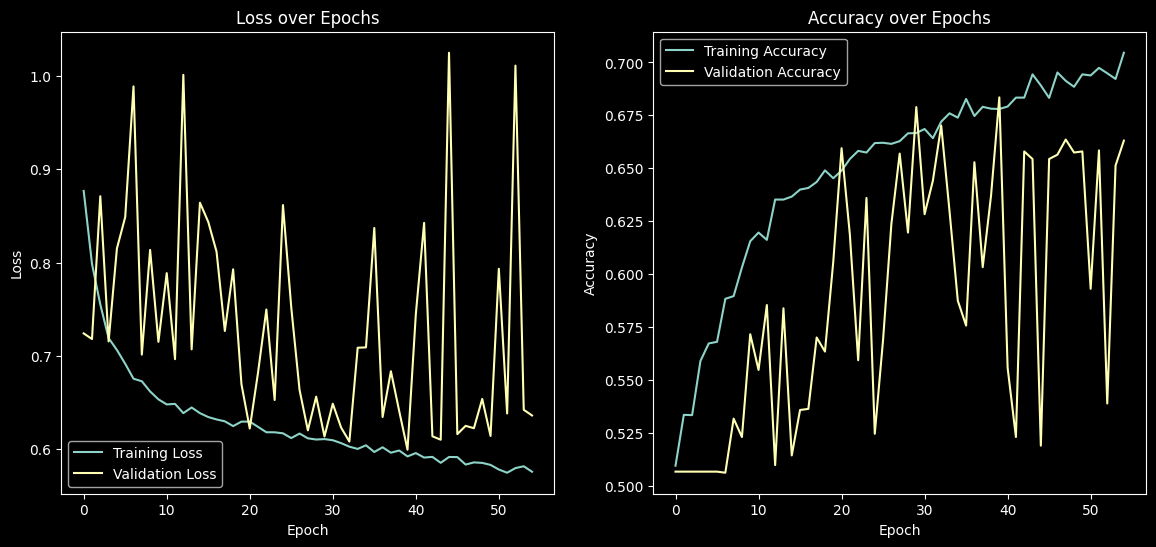

In [ ]:
# 3. Plot Training History (as in your previous code)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Starting model evaluation...
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.7892 - loss: 0.4715

--- Evaluation Results ---
Test Loss: 0.6226
Test Accuracy: 0.6637
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step
Accuracy: 0.6637
Precision (macro): 0.6949
Recall (macro): 0.6648
F1-score (macro): 0.6506


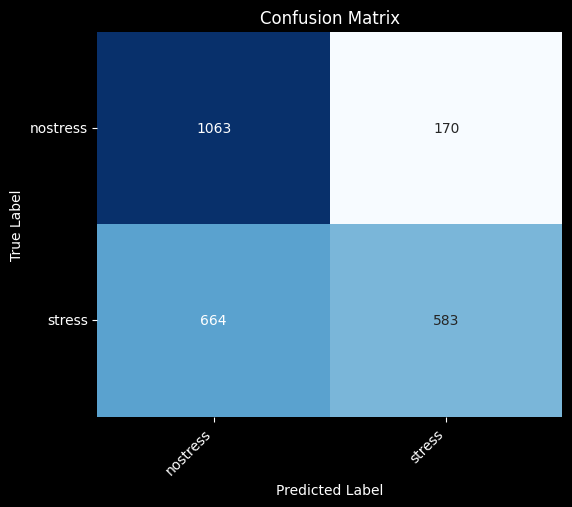

Evaluation finished.


In [ ]:
# 4. Evaluate on Test Set
# Pass the test_set generator directly
evaluate_model(trained_model, test_set)

In [ ]:
# Save the trained model to the current working directory
trained_model.save('model.h5')
print("Model saved as model.h5 in the notebook's directory.")

Model saved as model.h5 in the notebook's directory.


In [ ]:
# This cell is redundant as ImageDataGenerators are correctly set up in cell k9w2jplxDxf5